In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import torchvision.transforms as T
from preprocessing.DateCategories import ultra_for_model
from PIL import Image
from torch.utils.data import Dataset, DataLoader

torch.cuda.empty_cache()
torch.manual_seed(19)
np.random.seed(19)
torch.backends.cudnn.deterministic = True
torch.cuda.manual_seed(19)

### Пути

In [2]:
root_image = 'C:/Users/tolik/information_technology/third_year/practice_project/CoreAnalysis-ML/data_for_study/photos/'
root_masks = 'C:/Users/tolik/information_technology/third_year/practice_project/CoreAnalysis-ML/data_for_study/labels/'
root_masks_rgb = 'C:/Users/tolik/information_technology/third_year/practice_project/CoreAnalysis-ML/data_for_study/labels_png/'

### Инструменты для работы

In [13]:
def visual_img_and_mask(photo_id, roots, photo_type='ultraviolet'):
    image = Image.open(roots[0] + '{}.jpeg'.format(photo_id))
    mask = Image.open(roots[1] + photo_type + '/label_{}.png'.format(photo_id))
    mask_npz = np.load(roots[2] + photo_type + '/label_{}.npz'.format(photo_id))
    image = np.asarray(image)
    mask = np.asarray(mask)
    image = cv2.resize(image, (512, 7680))
    mask = cv2.resize(mask, (512, 7680))
    mask_npz = mask_npz['x']
    mask_npz = cv2.resize(mask_npz, (512, 7680))
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 20))

    axes[0].imshow(image)
    axes[0].set_title('image')

    axes[1].imshow(mask)
    axes[1].set_title('mask')

    axes[2].imshow(mask_npz)
    axes[2].set_title('mask_npz')

    print('Size of Mask: {}\n'
          'Size of image: {}\n'
          'Size of Mask_npz: {}\n'
          .format(mask.shape, image.shape, mask_npz.shape))

### Гиперпараметры

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1

### Данные для обучения

In [15]:
# разобьем все изображения на тренировочную, тестовую, валидационную части
X_train, X_test = train_test_split(ultra_for_model[:200], test_size = 0.2, random_state = 19)
X_train, X_val = train_test_split(X_train, test_size = 0.1, random_state = 19)

print('Размер X_train: {}\n'
      'Размер X_test: {}\n'
      'Размер X_val: {}'
      .format(len(X_train), len(X_test), len(X_val)))

Размер X_train: 144
Размер X_test: 40
Размер X_val: 16


Size of Mask: (7680, 512, 3)
Size of image: (7680, 512, 3)
Size of Mask_npz: (7680, 512)



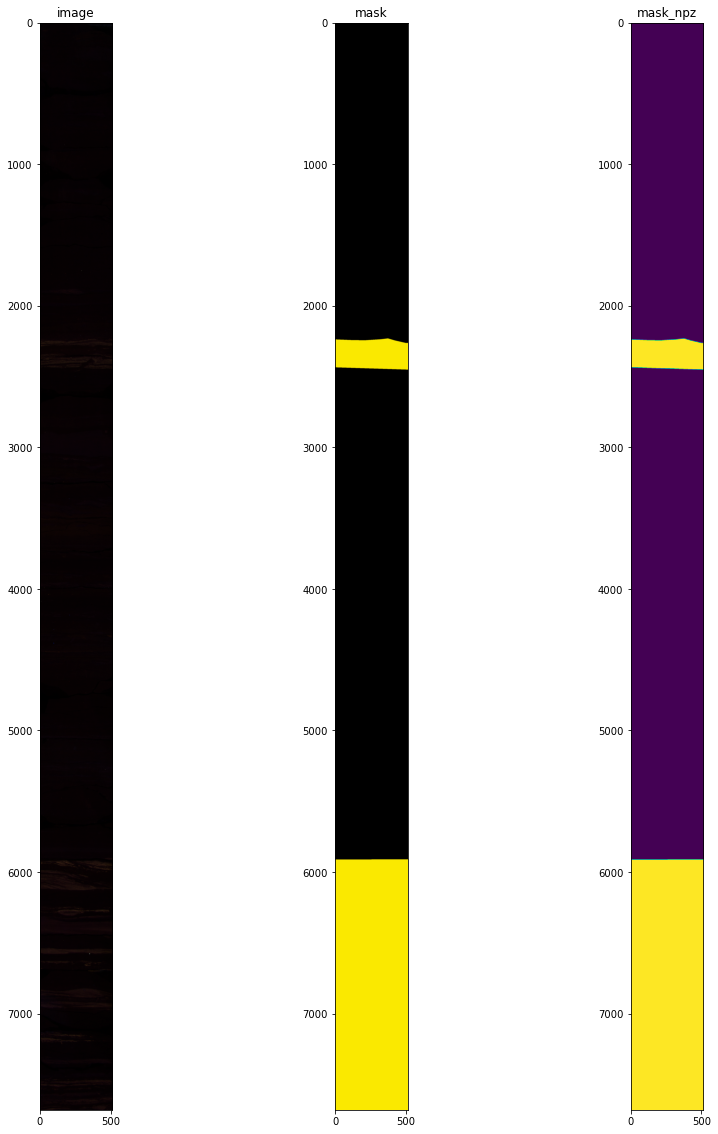

In [16]:
visual_img_and_mask(1006679, [root_image, root_masks_rgb, root_masks])

Определим итератор для наших данных, который сможет возвращать уже предобработанные(Resize + Convert to tensor) пары (изображение, маска)

In [43]:
class UltravioletDataset(Dataset):
    classes = ['Насыщенное', 'Отсутствует', 'Карбонатное']
    def __init__(self, image_path, mask_path, data,
                 mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], transform=None):
        self.image_path = image_path
        self.mask_path = mask_path
        self.data = data # хранилище ID-шников
        self.transform = transform
        self.std = std
        self.mean = mean
    def __len__(self):
        # количество изображений в датасете
        return len(self.data)
    
    def __getitem__(self, idx):
        # возвращаем изображение с маской по индексу в data
        # загрузка
        img = Image.open(self.image_path + str(self.data[idx]) + '.jpeg')
        mask = np.load(self.mask_path + 'ultraviolet/label_' + str(self.data[idx]) + '.npz')['x']
        
        # аугментации (если есть)
        if self.transform is not None:
            img = self.transform(img)
            mask = self.transform(mask)
        # обязательные преобразования
        t = T.Compose([
                T.ToTensor(),
                T.Normalize(self.mean, self.std)
            ])
        img = t(img)
        c, h, w = img.shape
        h = h // 512 * 512
        w = w // 512 * 512
        img = T.Resize([h, w])(img)
        mask = cv2.resize(mask, (w, h))
        mask = torch.from_numpy(mask)
        print('before extracting we have: size of img: {}, size of mask: {}'.
             format(img.shape, mask.shape))
        
        # разбивка на патчи
        img_patches = img.unfold(1, w, step=w)
        img_patches = img.contiguous().permute(1, 0, 2, 3)
        img_patches.view(3, -1, h, w)
        mask_patches = mask.unfold(0, w, step = w)
        mask_patches = mask_patches.view(-1, h, w)
        
        print('After extracting on patches we have size of image: {}'.format(img_patches.shape))
        print('After extracting on patches we have size of mask: {}'.format(mask_patches.shape))
        
        return img_patches, mask_patches

In [44]:
# определим итераторы для тестового и валидационного датасетов
train_set = UltravioletDataset(image_path = root_image,
                               mask_path = root_masks,
                               data = X_train)
val_set = UltravioletDataset(image_path = root_image,
                               mask_path = root_masks,
                               data = X_val)
test_set = UltravioletDataset(image_path = root_image,
                               mask_path = root_masks,
                               data = X_test)

In [45]:
# Загрузчики данных
train_dataloader = DataLoader(dataset=train_set,
                              batch_size=batch_size,
                              shuffle=True)
val_dataloader = DataLoader(dataset=val_set,
                              batch_size=batch_size,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_set,
                            batch_size=batch_size,
                            shuffle=True)

### Создание и обучение модели

In [46]:
import segmentation_models_pytorch as smp

classes = ['Насыщенное', 'Отсутствует', 'Карбонатное']
## encoder_depth - глубина encode-части. Если исходное изображение h * w,
## то в конце encode-слоя оно будет (h / 2**depth) * (w / 2**depth)

# Fully - convolution net
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

# чаще всего берут Adam с стандартным lr
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# т.к. с Dice могут быть проблемы из-за недифференцируемости,
# будем исп. Crossentropy и Dice как вспомогательную
loss = smp.utils.losses.CrossEntropyLoss()
loss_help = smp.utils.losses.DiceLoss()
metric = [smp.utils.metrics.IoU(threshold=0.5)]

In [47]:
train_epoch = smp.utils.train.TrainEpoch(
        model = model, loss=loss,
        metrics = metric, optimizer=optimizer,
        device=device, verbose=True)
val_epoch = smp.utils.train.ValidEpoch(
        model = model, loss=loss,
        metrics = metric,
        device=device, verbose=True)
for e in range(1, 21):
    print('Epoch: {} / 10'.format(e))
    train_res = train_epoch.run(train_dataloader)
    val_res = val_epoch.run(val_dataloader)
    
    if e % 10 == 0:
        oprimizer.param_groups[0]['lr'] /= 100

Epoch: 1 / 10
train:   0%|                                                                                   | 0/144 [00:00<?, ?it/s]


RuntimeError: number of dims don't match in permute